In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import numpy as np
import scipy

from tqdm import tqdm 

import os

import matplotlib.pyplot as plt
from neurorient import NeurOrient
from neurorient.utils_visualization import save_mrc
from neurorient.reconstruction.phasing import PhaseRetriever
from neurorient.utils_visualization import display_volumes

import h5py
from pytorch3d.transforms import matrix_to_quaternion

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
pdb = '3IZN'
poisson = True
num_images = 10000
increase_factor = 10

In [3]:
spi_data = torch.load(f'/pscratch/sd/z/zhantao/neurorient_repo/data/{pdb}_increase{increase_factor:d}_poisson{poisson}_num{num_images//1000:d}K.pt')
ckpt_path = '/pscratch/sd/z/zhantao/neurorient_repo/model_archived/lightning_logs/version_14754746/checkpoints/last.ckpt'
model_dir = '/pscratch/sd/z/zhantao/neurorient_repo/model_archived'
save_dir = '/pscratch/sd/z/zhantao/neurorient_repo/data'
print(spi_data.keys())

dict_keys(['orientations', 'intensities', 'pixel_position_reciprocal', 'pixel_index_map', 'volume', 'img_real_mesh', 'vol_real_mesh', 'time_stamp'])


In [4]:
model = NeurOrient.load_from_checkpoint(ckpt_path)

In [5]:
scale_factor = model.photons_per_pulse * 1e-12

In [6]:
model.to(device)

grid_reciprocal = np.pi * model.grid_position_reciprocal / model.grid_position_reciprocal.max()
with torch.no_grad():
    intensity = model.predict_intensity(grid_reciprocal.to(device))
intensity_pred = (torch.exp(intensity) - 1).cpu().numpy() / scale_factor

In [7]:
model.grid_position_reciprocal.shape

torch.Size([128, 128, 128, 3])

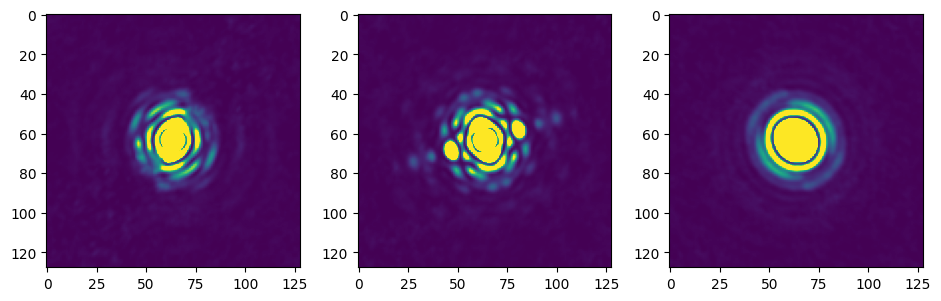

In [8]:
display_volumes(intensity_pred, closefig=False, vmin=0, vmax=1e-3 * intensity_pred.max())

In [9]:
saved_data = torch.load('/pscratch/sd/z/zhantao/neurorient_repo/data/5BWK_increase100_poissonTrue_num10K.pt')

In [10]:
volume = saved_data['volume']

/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor([3., 3., 3.]) tensor(True)
0 tensor([-23.,   1., -31.]) tensor(False)
1 tensor([-23.,   1., -31.]) tensor(True)
1 tensor([ -1.,   0., -37.]) tensor(False)
2 tensor([ -1.,   0., -37.]) tensor(True)
2 tensor([ 0.,  0., -2.]) tensor(False)


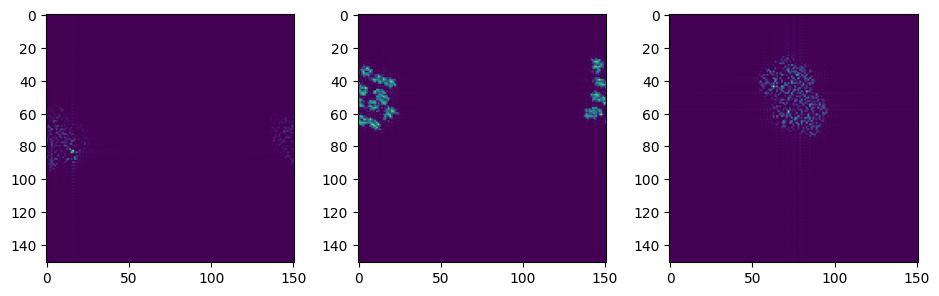

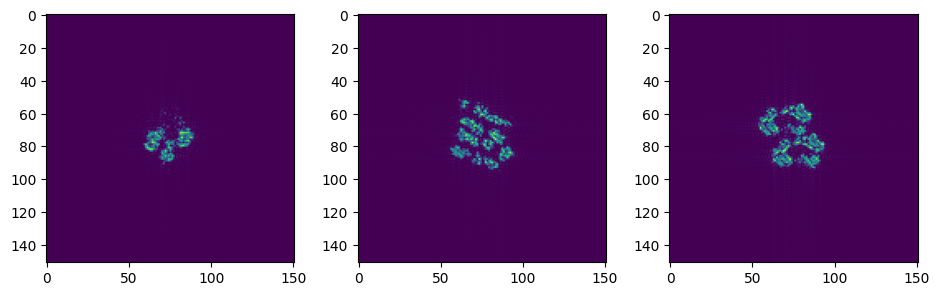

In [11]:
from neurorient.reconstruction.phasing import recenter

real_volume = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(volume)).real).clamp(0.)
display_volumes(real_volume, closefig=False)
real_volume = torch.fft.fftshift(recenter(
    torch.fft.ifftshift(real_volume), torch.ones_like(real_volume), M=real_volume.shape[-1]
)[0])
display_volumes(real_volume, closefig=False)

In [12]:
from neurorient.external.spinifel import center_volume, rotate_volume, align_volumes


/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/skopi/diffraction.py:76: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_phase(atom_pos, q_xyz):
/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/skopi/diffraction.py:90: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def cal(f_hkl, atom_pos, q_xyz, xyz_ind, pixel_number):
/pscratch/sd/z

In [13]:
quat = np.random.rand(1,4)
quat = quat / np.linalg.norm(quat, axis=1, keepdims=True)

In [14]:
rot_real_volume = rotate_volume(real_volume, quat)[0]

In [102]:
from neurorient.metrics import compute_fsc
from neurorient.reconstruction.slicing import real_mesh_2_reciprocal_mesh

In [96]:
saved_data['volume'].abs().pow(2).max()

tensor(7.6119e+10)

In [98]:
intensity_pred.max()

188.86392

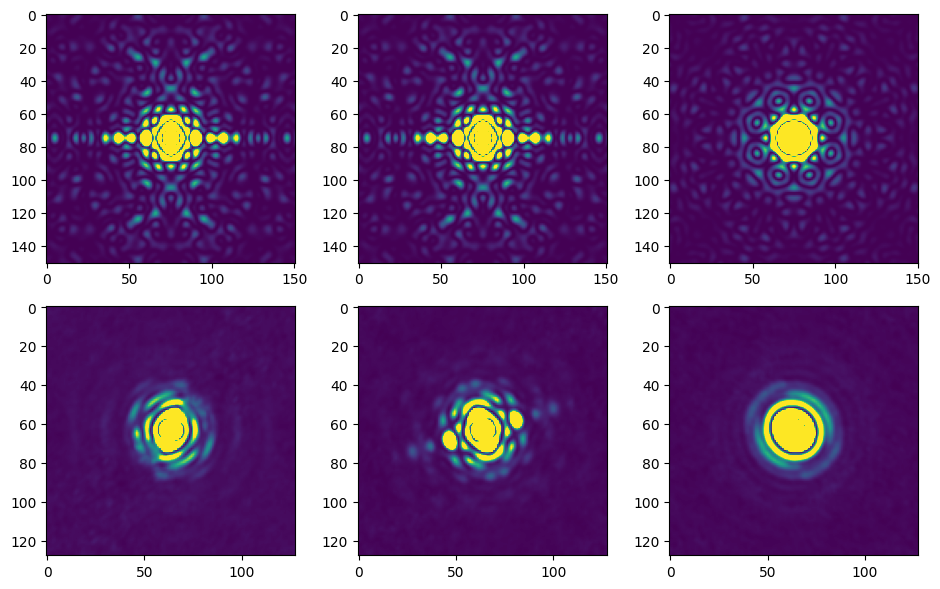

In [101]:
display_volumes([spi_data['volume'].abs().pow(2) / spi_data['volume'].abs().pow(2).max(), intensity_pred/intensity_pred.max()], closefig=False, vmax=0.001)
# display_volumes(saved_data['volume'].abs().pow(2), closefig=False)

In [110]:
compute_fsc(
    spi_data['volume'].abs().pow(2) / spi_data['volume'].abs().pow(2).max(),
    real_mesh_2_reciprocal_mesh(saved_data['vol_real_mesh']), 
    intensity_pred/intensity_pred.max(),
    model.grid_position_reciprocal,
    volume_type='intensity')

Initial CC between unzoomed / unfiltered volumes is: 0.808
Alignment CC after rotation is: 0.838
Map had to be inverted
Final CC between unzoomed / unfiltered volumes is: 0.824
Estimated resolution from largest-q: at least 11.6 Angstrom


(11.606679170310002,
 array([0.00175831, 0.00527494, 0.00879156, 0.01230818, 0.01582481,
        0.01934143, 0.02285806, 0.02637468, 0.0298913 , 0.03340793,
        0.03692455, 0.04044118, 0.0439578 , 0.04747442, 0.05099105,
        0.05450767, 0.0580243 , 0.06154092, 0.06505754, 0.06857417,
        0.07209079, 0.07560742, 0.07912404, 0.08264066, 0.08615729]),
 array([0.98137222, 0.88984878, 0.84678647, 0.93191956, 0.75368668,
        0.92847878, 0.8720003 , 0.83058644, 0.87905459, 0.90852845,
        0.86601453, 0.86556446, 0.90053337, 0.91234125, 0.87950888,
        0.85795769, 0.87085947, 0.87748708, 0.86727435, 0.8514893 ,
        0.85731731, 0.85240135, 0.84327194, 0.84362667, 0.84078791]))

In [ ]:
compute_fsc(
    real_volume, 
    saved_data['vol_real_mesh'], 
    rot_real_volume,
    volume_type='intensity')

Initial CC between unzoomed / unfiltered volumes is: 0.323
Alignment CC after rotation is: 0.798
Final CC between unzoomed / unfiltered volumes is: 0.851
Estimated resolution from FSC: 10.3 Angstrom


(10.279015705015096,
 array([0.00207632, 0.00622896, 0.0103816 , 0.01453424, 0.01868688,
        0.02283952, 0.02699216, 0.0311448 , 0.03529744, 0.03945008,
        0.04360272, 0.04775536, 0.051908  , 0.05606064, 0.06021328,
        0.06436592, 0.06851856, 0.0726712 , 0.07682384, 0.08097648,
        0.08512912, 0.08928176, 0.0934344 , 0.09758704, 0.10173968,
        0.10589232, 0.11004496, 0.1141976 , 0.11835024, 0.12250288]),
 array([0.99940473, 0.99759287, 0.99309748, 0.98359114, 0.97913486,
        0.97042441, 0.96902758, 0.9572705 , 0.93119943, 0.91730338,
        0.88554078, 0.85988516, 0.84386533, 0.82279402, 0.78424925,
        0.76332337, 0.73028105, 0.70061082, 0.69462919, 0.66560942,
        0.64043945, 0.5988825 , 0.54069018, 0.49681488, 0.45845112,
        0.40684897, 0.38128   , 0.38879779, 0.37457475, 0.31985804]))

In [72]:
rot_vol, _, _ = align_volumes(rot_real_volume, real_volume, zoom=0.5, n_search=420)

Initial CC between unzoomed / unfiltered volumes is: 0.340
Alignment CC after rotation is: 0.849
Final CC between unzoomed / unfiltered volumes is: 0.936


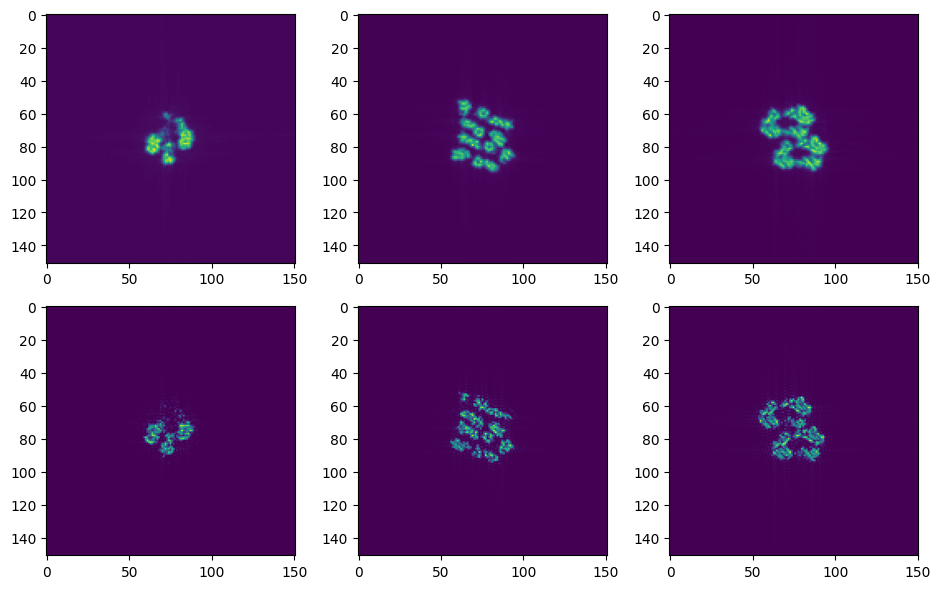

In [73]:
display_volumes([rot_vol, real_volume], closefig=False)